# #30DayMapChallenge - Día 1: Puntos
## Caso de Negocio: Análisis de Saturación de Mercado (Cafeterías en CDMX, 2025)

**Autor:** Mario Ignacio Ibañez Castro | **Rol:** Data Scientist & Strategic Planner

### El objetivo
No se trata solo de ver "dónde están las cafeterías". El objetivo es identificar **zonas de canibalización** (donde la competencia es excesiva) vs. **océanos azules** (zonas desatendidas).

**Fuente de Datos:** DENUE (INEGI) - Directorio Estadístico Nacional de Unidades Económicas para la Ciudad de México 2025.

In [57]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx # Librería clave para mapas base estéticos

# Configuración de estilo para gráficos de alta calidad
plt.style.use('dark_background') # El modo oscuro nos ayudad a resaltar de mejor manera la densidad de puntos
%matplotlib inline

### 1. Ingesta y Limpieza de Datos (ETL)
Cargamos el dataset  del INEGI. Para optimizar memoria, solo leemos las columnas críticas. Filtramos por el código SCIAN **722515** (Cafeterías, fuentes de sodas, neverías).

In [58]:
# RUTA DEL ARCHIVO (Asegúrate de cambiar esto a tu ruta real)
ruta_denue = r'C:\Users\mario\Documents\30DaysMapChallenge\Dia_1_puntos\00_Datos\denue_09_csv\conjunto_de_datos\denue_inegi_09_.csv' # 09 es CDMX

In [59]:
# Columnas estrictamente necesarias
cols = ['codigo_act', 'nombre_act', 'latitud', 'longitud']

# Carga de datos
df = pd.read_csv(ruta_denue, encoding='latin-1', usecols=cols)

# Filtrado: Cafeterías (SCIAN 722515)
df_cafes = df[df['codigo_act'] == 722515].copy()

In [60]:
df_cafes.head()

,codigo_act,nombre_act,latitud,longitud
332162,722515,"Cafeterías, fuentes de sodas, neverías, refres...",19.376267,-99.099480
332163,722515,"Cafeterías, fuentes de sodas, neverías, refres...",19.484953,-99.148697
332165,722515,"Cafeterías, fuentes de sodas, neverías, refres...",19.460776,-99.146976
332166,722515,"Cafeterías, fuentes de sodas, neverías, refres...",19.352442,-99.161211
332204,722515,"Cafeterías, fuentes de sodas, neverías, refres...",19.374170,-99.159315


In [61]:
# Limpieza: Eliminar coordenadas nulas (en el caso de que las haya)
df_cafes = df_cafes.dropna(subset=['latitud', 'longitud'])

print(f"Total de cafeterías analizadas: {len(df_cafes)}")

Total de cafeterías analizadas: 9797


In [62]:
# Conversión a GeoDataFrame (Sistema de Coordenadas GPS: EPSG 4326)
gdf = gpd.GeoDataFrame(
    df_cafes, 
    geometry=gpd.points_from_xy(df_cafes.longitud, df_cafes.latitud),
    crs="EPSG:4326"
)

# Reproyección a Web Mercator (EPSG 3857) para coincidir con mapas base (Google/Bing/OSM)
gdf_web = gdf.to_crs(epsg=3857)

### 2. Diseño Visual
Aplicamos los siguientes principios:

1.  **Eliminación de Ruido (Chartjunk):** Quitamos ejes (lat/lon) y bordes.
2.  **Uso del Color:** Usamos un color "Fuego" (`#FF4500`) con **transparencia (alpha)**. Esto permite que las zonas con muchos puntos se vean más brillantes ("calientes") orgánicamente.
3.  **Anotaciones:** Colocamos el insight directamente en el mapa.

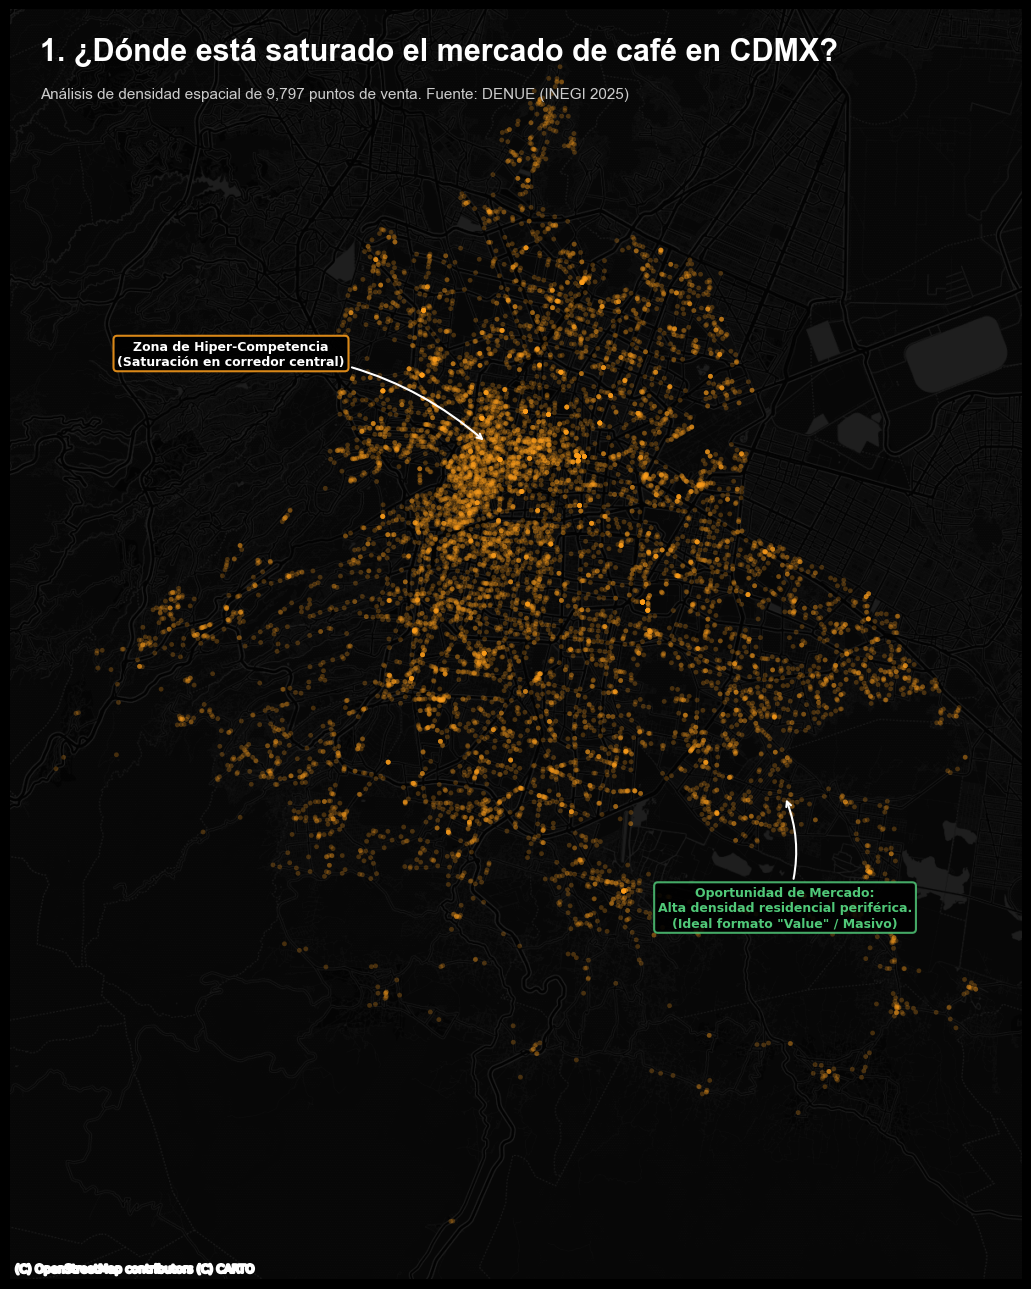

Mapa exportado exitosamente como: Dia1_Saturacion_Mercado_MIIC.png


In [63]:
# CONFIGURACIÓN DE LA FIGURA
fig, ax = plt.subplots(figsize=(12, 13))
fig.patch.set_facecolor('black')

# 1. LOS DATOS
gdf_web.plot(
    ax=ax,
    markersize=12,
    color='#FF9F1C',
    alpha=0.25,
    edgecolor='none',
    zorder=2
)

# 2. EL ENCUADRE (Auto-Crop Inteligente) 
# Se mantiene el cálculo automático del bounding box
minx, miny, maxx, maxy = gdf_web.total_bounds
margin_x = (maxx - minx) * 0.05
margin_y = (maxy - miny) * 0.05
ax.set_xlim(minx - margin_x, maxx + margin_x)
ax.set_ylim(miny - margin_y, maxy + margin_y)

# 3. EL CONTEXTO URBANO (Mapa Base) 
# Utilizammos un mapa base oscuro para resaltar el contraste con los puntos naranjas
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.DarkMatterNoLabels,
    zoom_adjust=1,
    alpha=0.8,
    zorder=1
)

# 4. Títulos
# TÍTULO PRINCIPAL
ax.text(
    x=0.03, y=0.96,
    s="1. ¿Dónde está saturado el mercado de café en CDMX?",
    transform=ax.transAxes,
    fontsize=22, fontweight='bold', color='white', fontname='Arial', zorder=3
)

# SUBTÍTULO
ax.text(
    x=0.03, y=0.93,
    s=f"Análisis de densidad espacial de {len(gdf_web):,} puntos de venta. Fuente: DENUE (INEGI 2025)",
    transform=ax.transAxes,
    fontsize=11, color='#cccccc', fontname='Arial', zorder=3
)

# 5. ANOTACIONES INTEGRADAS (Rediseñadas) 
# las cajas se posicionan directamente sobre las zonas de interés.

# Anotación 1: Zona de Hiper-Competencia (Centro brillante)
ax.annotate(
    'Zona de Hiper-Competencia\n(Saturación en corredor central)',
    xy=(-11038500, 2206000), # Coordenada aproximada del punto de interés
    xytext=(-11050000, 2210000), # Texto en la misma posición
    arrowprops=dict(facecolor='#FF9F1C', edgecolor='white', arrowstyle='->', lw=1.5, connectionstyle="arc3,rad=-0.2"),
    fontsize=9, # Fuente más pequeña
    color='white', fontweight='bold', ha='center', va='center', # Centrado
    bbox=dict(boxstyle="round,pad=0.3", fc="black", ec="#FF9F1C", lw=1.5, alpha=0.85), zorder=4
)

# Anotación 2: Oportunidad de Mercado (Sur/Periferia)
ax.annotate(
    'Oportunidad de Mercado:\nAlta densidad residencial periférica.\n(Ideal formato "Value" / Masivo)',
    xy=(-11025000, 2190000), # Coordenada aproximada para la zona sur
    xytext=(-11025000, 2185000), # Texto en la misma posición
    arrowprops=dict(facecolor='#50C878', edgecolor='white', arrowstyle='->', lw=1.5, connectionstyle="arc3,rad=0.2"),
    fontsize=9, # Fuente más pequeña
    color='#50C878', fontweight='bold', ha='center', va='center', # Centrado
    bbox=dict(boxstyle="round,pad=0.3", fc="black", ec="#50C878", lw=1.5, alpha=0.85), zorder=4
)


#  LIMPIEZA FINAL Y EXPORTACIÓN 
ax.set_axis_off()
plt.tight_layout()

# Guardar en alta resolución
output_filename = "Dia1_Saturacion_Mercado_MIIC.png"
plt.savefig(output_filename, dpi=1200, bbox_inches='tight', facecolor='black')
plt.show()

print(f"Mapa exportado exitosamente como: {output_filename}")

### 3. Normalización de cafeterías que no estaban bien clasificadas

In [64]:
# Paso 1: LIBRERÍAS Y CONFIGURACIÓN 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Configuración visual
plt.style.use('dark_background')
%matplotlib inline

# Paso 2: CARGA DE DATOS (ETL) 
# RUTA DEL ARCHIVO (Asegúrate de que sea la correcta)
ruta_denue = r'C:\Users\mario\Documents\30DaysMapChallenge\Dia_1_puntos\00_Datos\denue_09_csv\conjunto_de_datos\denue_inegi_09_.csv' # CDMX

# Agregamos 'nom_estab' a la lista de carga original.
cols_a_cargar = ['nom_estab', 'codigo_act', 'nombre_act', 'latitud', 'longitud']

# Leemos el CSV asegurando el encoding latin-1
df = pd.read_csv(ruta_denue, encoding='latin-1', usecols=cols_a_cargar)

# Aseguramos que el código de actividad sea texto (string) para evitar errores de comparación
df['codigo_act'] = df['codigo_act'].astype(str)

In [65]:
#  Paso 3:  DATA CLEANING  

# 1. Definir el Target Oficial (Cafeterías según INEGI)
codigo_cafeteria = '722515'

# 2. Definir Patrones de Búsqueda (Regex)
# Buscamos variantes ortográficas y marcas clave
keywords = r'CAFETERIA|CAFETERÍA|CAFE|CAFÉ|COFFEE'

# 3. FILTRADO DOBLE
# A: Las que YA eran cafeterías oficialmente
df_oficial = df[df['codigo_act'] == codigo_cafeteria].copy()

# B: Las "Escondidas" (Tienen el nombre PERO NO el código)
mask_hidden = (
    df['nom_estab'].str.contains(keywords, case=False, na=False, regex=True) & 
    (df['codigo_act'] != codigo_cafeteria)
)
df_hidden = df[mask_hidden].copy()

# 4. RESULTADOS DE LA AUDITORÍA
print(f"Cafeterías Oficiales (SCIAN {codigo_cafeteria}): {len(df_oficial):,}")
print(f"Cafeterías 'Rescatadas' (Reclasificadas): {len(df_hidden):,}")
incremento = (len(df_hidden) / len(df_oficial)) * 100
print(f"Incremento de datos para el mapa: +{incremento:.1f}%")

# 5. UNIFICACIÓN
# Unimos ambos datasets para el mapa final
df_final = pd.concat([df_oficial, df_hidden])

# Convertimos a GeoDataFrame (Proyección Web Mercator para el mapa)
gdf_final = gpd.GeoDataFrame(
    df_final, 
    geometry=gpd.points_from_xy(df_final.longitud, df_final.latitud),
    crs="EPSG:4326"
).to_crs(epsg=3857)

print(f"Dataset Final listo: {len(gdf_final):,} puntos.")

Cafeterías Oficiales (SCIAN 722515): 9,797
Cafeterías 'Rescatadas' (Reclasificadas): 1,079
Incremento de datos para el mapa: +11.0%
Dataset Final listo: 10,876 puntos.


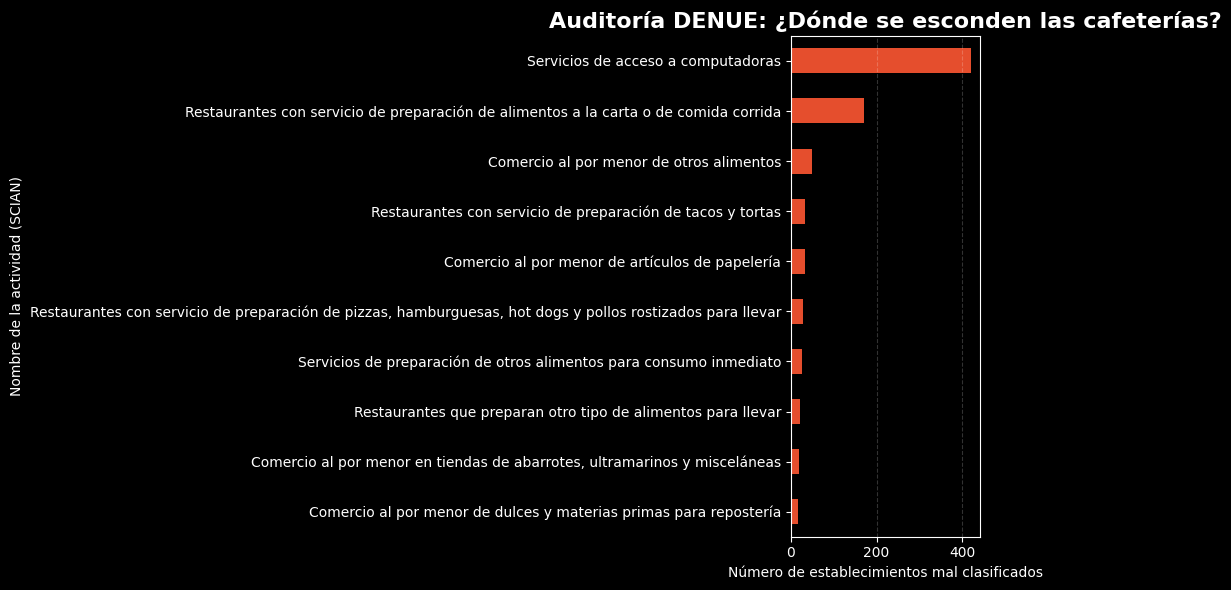

In [66]:
# Paso 4: VISUALIZACIÓN DE LA "SUCIEDAD" DE DATOS

# Contamos dónde estaban escondidas (Top 10 categorías erróneas)
top_wrong_cats = df_hidden['nombre_act'].value_counts().head(10)

# Crear gráfica
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Plot bar horizontal
top_wrong_cats.sort_values().plot(kind='barh', color='#FF5733', alpha=0.9, ax=ax)

# Estilizado
ax.set_title('Auditoría DENUE: ¿Dónde se esconden las cafeterías?', fontsize=16, color='white', fontweight='bold')
ax.set_xlabel('Número de establecimientos mal clasificados', color='white')
ax.set_ylabel('Nombre de la actividad (SCIAN)', color='white')
ax.tick_params(colors='white')
ax.grid(axis='x', alpha=0.2, linestyle='--')

# Guardar
plt.tight_layout()
plt.savefig('Dia1_Auditoria_Datos.png', dpi=300, facecolor='black')
plt.show()

Categoría 'Servicios de acceso a computadoras' eliminada.
Total de cafeterías recuperadas (limpias): 659


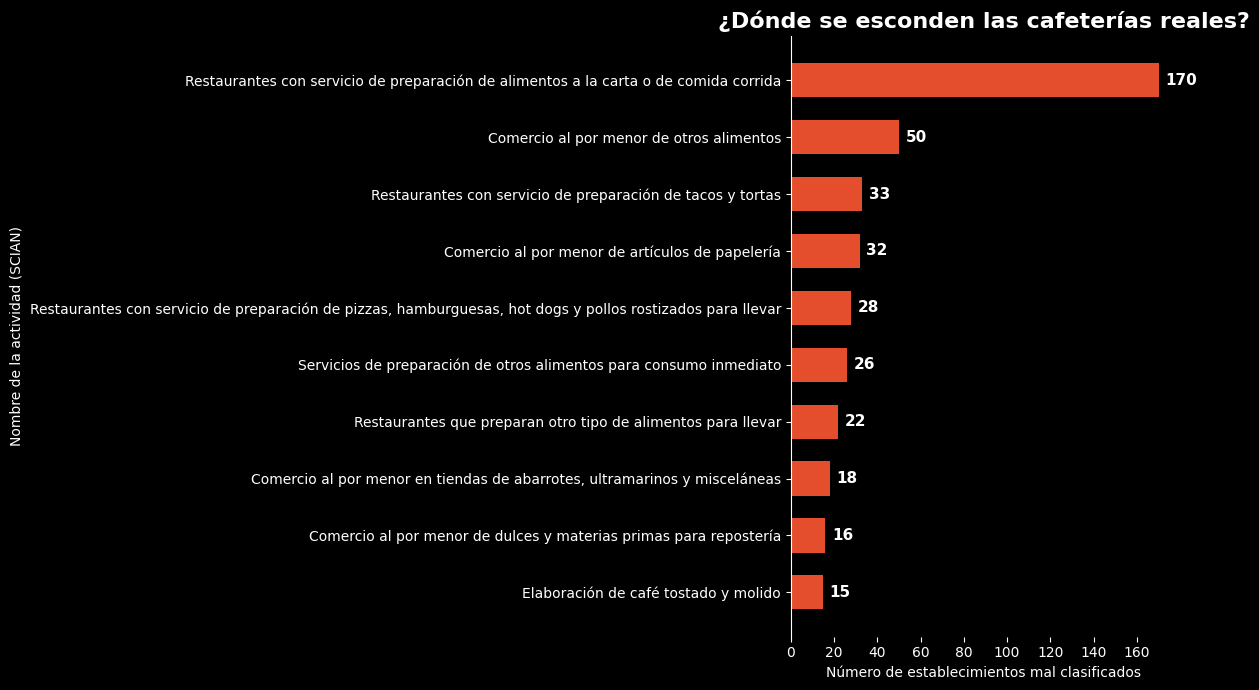

In [67]:
# Paso 4.1. FILTRADO RÁPIDO: Quitamos los "Cíber Cafés" del dataframe actual ya que no son cafeterías reales
categoria_a_eliminar = "Servicios de acceso a computadoras"
df_hidden = df_hidden[df_hidden['nombre_act'] != categoria_a_eliminar].copy()

print(f"Categoría '{categoria_a_eliminar}' eliminada.")
print(f"Total de cafeterías recuperadas (limpias): {len(df_hidden)}")

# 2. PREPARAR DATOS PARA GRAFICAR
# Recalculamos el Top 10 sin los cíbers y ordenamos
top_wrong_cats = df_hidden['nombre_act'].value_counts().head(10).sort_values()

# 3. GRAFICAR DE NUEVO
fig, ax = plt.subplots(figsize=(12, 7))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Generar barras
bars = ax.barh(top_wrong_cats.index, top_wrong_cats.values, color='#FF5733', alpha=0.9, height=0.6)

# CICLO PARA PONER EL CONTADOR AL LADO DE CADA BARRA
for bar in bars:
    width = bar.get_width()
    ax.text(
        x=width + 3,                         
        y=bar.get_y() + bar.get_height()/2, 
        s=f'{int(width)}',                   
        ha='left', va='center',
        color='white', fontsize=11, fontweight='bold'
    )

# Estilizado
ax.set_title('¿Dónde se esconden las cafeterías reales?', fontsize=16, color='white', fontweight='bold')
ax.tick_params(colors='white', labelsize=10) # Etiquetas blancas
ax.set_xlabel('Número de establecimientos mal clasificados', color='white')
ax.set_ylabel('Nombre de la actividad (SCIAN)', color='white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_color('white')

plt.tight_layout()
plt.savefig('Dia1_Auditoria_Sin_Cibers.png', dpi=300, facecolor='black')
plt.show()

# 4. (IMPORTANTE) ACTUALIZAR EL DATASET FINAL PARA EL MAPA
# Como modificamos df_hidden, actualizamos gdf_final para que el mapa también salga limpio
df_final = pd.concat([
    df[df['codigo_act'] == codigo_cafeteria], # Las originales
    df_hidden                                 # Las recuperadas (ya sin cíbers)
])

gdf_final = gpd.GeoDataFrame(
    df_final, 
    geometry=gpd.points_from_xy(df_final.longitud, df_final.latitud),
    crs="EPSG:4326"
).to_crs(epsg=3857)

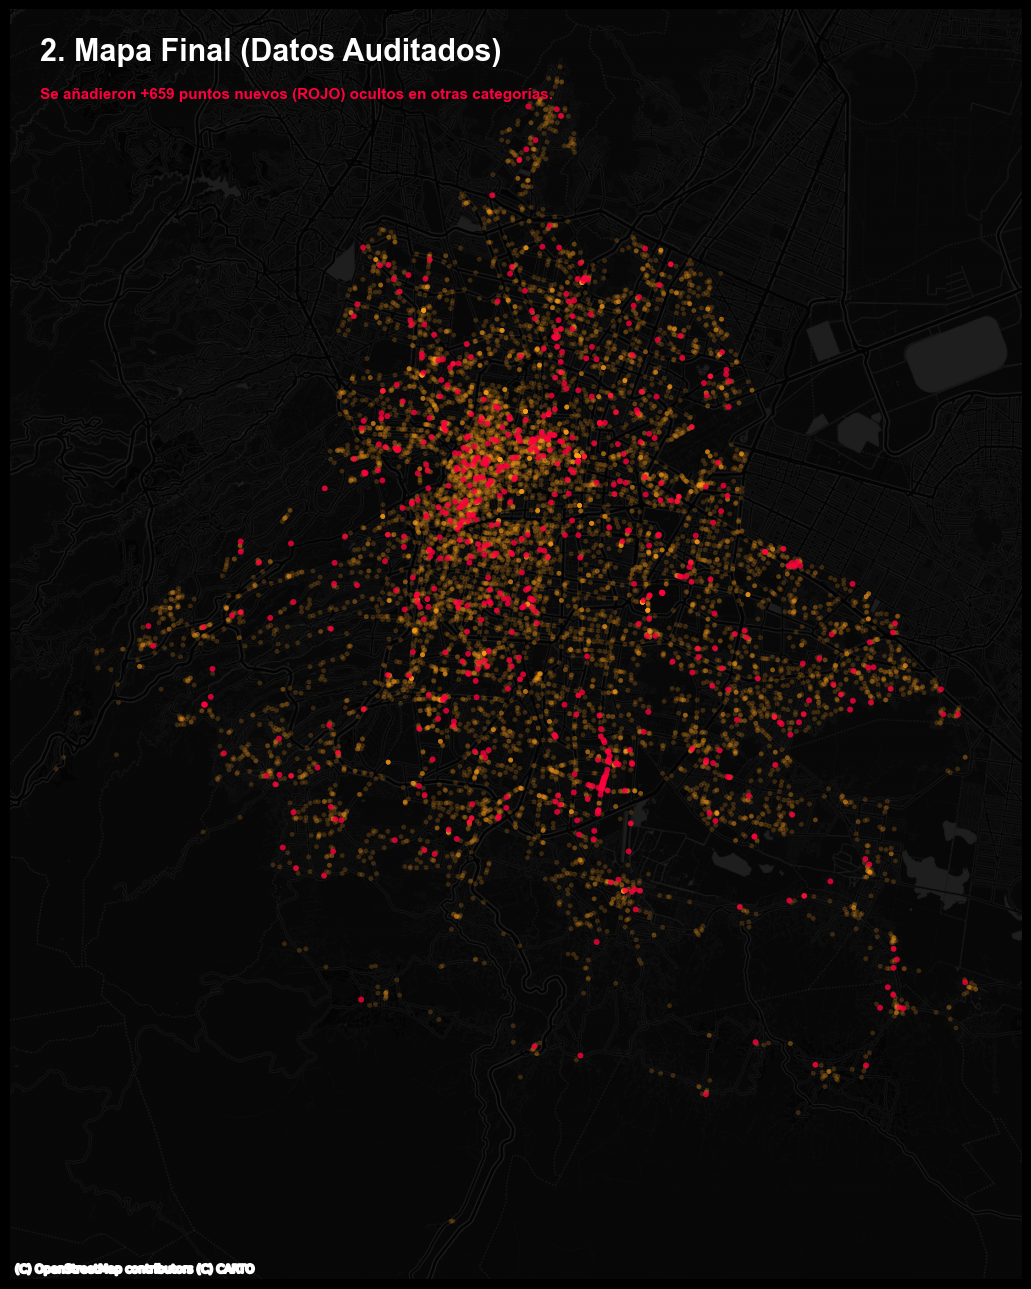

In [68]:
# Paso 5. CÓDIGO DEFINITIVO: MAPA FINAL

# 1. PREPARACIÓN DE CAPAS (Por si no están definidas en memoria)
# Separamos los datos oficiales de los recuperados por los de la auditoría
gdf_oficial = gdf_final[gdf_final['codigo_act'] == '722515']
gdf_recuperada = gdf_final[gdf_final['codigo_act'] != '722515']

# Calculamos los porcentajes para el texto
total_nuevos = len(gdf_recuperada)
porcentaje_aumento = round((len(gdf_recuperada) / len(gdf_oficial)) * 100)

# 2. CONFIGURACIÓN DE LA FIGURA
fig, ax = plt.subplots(figsize=(12, 13))
fig.patch.set_facecolor('black')

# 3. CAPA 1: DATOS OFICIALES (Naranja - Contexto)
gdf_oficial.plot(
    ax=ax,
    markersize=12,
    color='#FF9F1C', 
    alpha=0.20,      # Transparencia media para que hagan "bulto" pero no distraigan
    edgecolor='none',
    zorder=2
)

# 4. CAPA 2: DATOS RECUPERADOS (Rojo - El Hallazgo)
gdf_recuperada.plot(
    ax=ax,
    markersize=18,   # Ligeramente más grandes para destacar
    color='#FF003C', # Rojo Neón (Cyborg Red)
    alpha=0.8,       # Alta opacidad para que resalten sobre todo lo demás
    edgecolor='none',
    zorder=3         # Z-order alto para quedar encima
)

# 5. ENCUADRE (Auto-Crop Inteligente)
minx, miny, maxx, maxy = gdf_final.total_bounds
margin_x = (maxx - minx) * 0.05
margin_y = (maxy - miny) * 0.05
ax.set_xlim(minx - margin_x, maxx + margin_x)
ax.set_ylim(miny - margin_y, maxy + margin_y)

# 6. MAPA BASE
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.DarkMatterNoLabels,
    zoom_adjust=1,
    alpha=0.8,
    zorder=1
)

# 7. TEXTOS Y NARRATIVA
# Título Principal
ax.text(
    x=0.03, y=0.96,
    s="2. Mapa Final (Datos Auditados)",
    transform=ax.transAxes,
    fontsize=22, fontweight='bold', color='white', fontname='Arial', zorder=4
)

# Subtítulo (Explicando el color rojo)
ax.text(
    x=0.03, y=0.93,
    s=f"Se añadieron +{total_nuevos} puntos nuevos (ROJO) ocultos en otras categorías.",
    transform=ax.transAxes,
    fontsize=11, color='#FF003C', fontname='Arial', fontweight='bold', zorder=4
)

# 8. GUARDAR
ax.set_axis_off()
plt.tight_layout()
plt.savefig('Dia1_Mapa_Final_Definitivo.png', dpi=1200, bbox_inches='tight', facecolor='black')
plt.show()

In [71]:
!jupyter nbconvert --to pdf Puntos.ipynb

[NbConvertApp] Converting notebook Puntos.ipynb to pdf
[NbConvertApp] Support files will be in Puntos_files\
[NbConvertApp] Making directory .\Puntos_files
[NbConvertApp] Writing 63928 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2216468 bytes to Puntos.pdf
